In [37]:
# a script to open a file and store its content in a variable

def read_file(file: str):
    """ Open a file and return it's content
    Arg:
        file: The name of the file to open
    Return: contents of the file
    """
    if file:
        content = ""
        with open(file=file) as f:
            content = f.read()
        return content
    return "Please specify the file to read"

issue_label
bug            0.499523
enhancement    0.414129
question       0.086348
Name: proportion, dtype: float64
<------------------------------------------------------------------------------------->


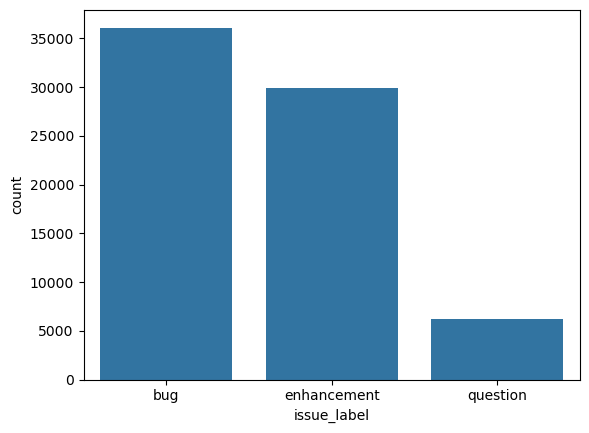

<------------------------------------------------------------------------------------->
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72289 entries, 0 to 72288
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   issue_url                 72289 non-null  object
 1   issue_label               72289 non-null  object
 2   issue_created_at          72289 non-null  object
 3   issue_author_association  72289 non-null  object
 4   repository_url            72289 non-null  object
 5   issue_title               72289 non-null  object
 6   issue_body                65141 non-null  object
 7   is_error                  72289 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 4.4+ MB
None


In [1]:
# Perform data analysis to understand the dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/sample1.csv')
#print(df.head())
# Check data Distribution with respect to labels
print(df['issue_label'].value_counts(normalize=True))
# Plot the distribution
print('<------------------------------------------------------------------------------------->')
sns.countplot(data=df, x='issue_label')
plt.show()
keywords = ['bug', 'error']
print('<------------------------------------------------------------------------------------->')
# try to create and add a feature
df['is_error'] = df['issue_title'].apply(lambda x: int(any(keyword in x.lower() for keyword in keywords)))
print(df.info())


/home/passwd/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


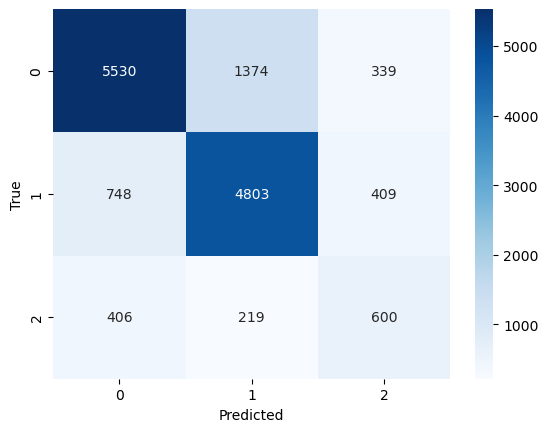

<------------------------------------------------------------------------------------->


'              precision    recall  f1-score   support\n\n           0       0.83      0.76      0.79      7243\n           1       0.75      0.81      0.78      5960\n           2       0.45      0.49      0.47      1225\n\n    accuracy                           0.76     14428\n   macro avg       0.67      0.69      0.68     14428\nweighted avg       0.76      0.76      0.76     14428\n'

<------------------------------------------------------------------------------------->


['random_forest.pkl']

In [1]:
# Building a Model with Random Forest Algorithm
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


def data_cleaner(file_path: str):
    """Performs Data cleaning and feature engineering tasks
    Arg:
        file_path: the path to a file containing data
    Return: clean dataframe.
    """
    try:
        data = pd.read_csv(file_path)

        # Drop rows with missing labels
        data = data.dropna(subset=['issue_label'])
        # Remove all duplicate rows
        data.drop_duplicates(inplace=True)
        # Fill missing values for other columns (if necessary)
        data['issue_body'] = data['issue_body'].fillna('')
        data['issue_title'] = data['issue_title'].fillna('')
        data['issue_author_association'] = data['issue_author_association'].fillna('unknown')
        # dropping unnecessary features
        data = data.drop(columns=['issue_url', 'repository_url', 'issue_created_at'])

        return data
    except FileNotFoundError as e:
        return "Please specify a complete path to the file with data"

def data_preprocessor(data):
    """
    Vectorization and feature engineering
    Arg:
        data: features from the raw data that are be be processed
    Return: preprocessed features into a single dataset
    """
    
    # TF-IDF Vectorizers for title and body
    title_vectorizer = TfidfVectorizer(stop_words='english')
    body_vectorizer = TfidfVectorizer(stop_words='english')
    # Encode author association
    encoder = OneHotEncoder(sparse_output=False)

    # fit the data
    title = title_vectorizer.fit(data['issue_title'])
    body = body_vectorizer.fit(data['issue_body'])
    author = encoder.fit(data['issue_author_association'].to_frame())

    # Save the encoders for later use
    joblib.dump(title_vectorizer, 'title_vectorizer.joblib')
    joblib.dump(body_vectorizer, 'body_vectorizer.joblib')
    joblib.dump(encoder, 'encoder.joblib')

    # Tranform that data
    title = title_vectorizer.transform(data['issue_title'])
    body = body_vectorizer.transform(data['issue_body'])
    author = encoder.transform(data['issue_author_association'].to_frame())

    # creation of extra features that could improve the model
    data['issue_title_length'] = data['issue_title'].apply(len)
    data['issue_body_length'] = data['issue_body'].apply(len)
    error_words = ['error', 'bug']
    enhance_words = ['feature', 'update', 'enhance', 'add']
    data['possible_title_error'] = data['issue_title'].apply(lambda x: int(any(word in x.lower() for word in error_words)))
    data['possible_body_error'] = data['issue_body'].apply(lambda x: int(any(word in x.lower() for word in error_words)))
    data['possible_title_update'] = data['issue_title'].apply(lambda x: int(any(word in x.lower() for word in enhance_words)))
    data['possible_body_update'] = data['issue_body'].apply(lambda x: int(any(word in x.lower() for word in enhance_words)))

    # combine all the features
    X = hstack([author,
                title,
                body,
                data[['issue_title_length',
                      'issue_body_length',
                      'possible_title_error',
                      'possible_body_error',
                      'possible_title_update',
                      'possible_body_update',
                      ]].values
                ])

    return X

def data_splitter(X, y):
    """Spliting preprocessed data into training and testing data
    Arg:
        X: preprocessed data to be split
        y: labels to the data
    Return: tuple of split data (X_train, X_test, y_train, y_test)
    """

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def model_trainer(X_train, y_train):
    """Trains the model
    Args:
        X_train: preprocessed training data without labels
        y_train: preprocessed training data labels
    Return: the trained model instance
    """
    param_dist = {
        "n_estimators": randint(80, 100),  # RandomizedSearchCV explores within this range
        "max_depth": [10, 20, 50, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "class_weight": ["balanced", "balanced_subsample"]
    }
    # hyperparameter tuning to improve model performance
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42), 
        param_distributions=param_dist,
        n_iter=20,  # Adjust this to control time vs. search breadth
        scoring='f1_macro',  # Use F1-macro to address class imbalance
        cv=3,  # 3-fold cross-validation
        random_state=42,
        n_jobs=-1  # Utilize all CPU cores
    )
    
    # train the model
    random_search.fit(X_train, y_train)

    return random_search

def model_evaluater(X_test, y_test, model):
    """Generate a model evaluation report using the unseen test data
    Args:
        X_test: preprocessed data without labels and previous unseen during training
        y_test: labels to this data which are used for evaluation
        model: the model to test
    Return: A dict of evaluation report and predicted values
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    return {
        'report': classification_report(y_test, y_pred),
        'y_pred': y_pred,
    }

def visualisation(y_pred, y_test):
    """visualise the model
    Arg:
        y_pred: predicted values
    """
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


data = data_cleaner('dataset/sample1.csv')
model_inputs = data.drop(columns=['issue_label'])
labels = data['issue_label'].to_frame()
#encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

X = data_preprocessor(model_inputs)
X_train, X_test, y_train, y_test = data_splitter(X, y)

model = model_trainer(X_train, y_train)
evaluation_data = model_evaluater(X_test, y_test, model)
y_pred = evaluation_data['y_pred']
visualisation(y_pred, y_test)
print('<------------------------------------------------------------------------------------->')
display(evaluation_data['report'])
print('<------------------------------------------------------------------------------------->')

# Store the model in a file
joblib.dump(model, 'random_forest.pkl')

